# Dự đoán lượt xem video trên Youtube

In [47]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stat

Upload và mô tả dữ liệu

In [48]:
data = pd.read_csv('BigDS.csv')
data.head()

,video_id,channel_id,channel_name,published_date,video_title,video_description,dislikes,likes,views,comment_count,favorite_count,category,subscribers,duration
0,iLBYhZcLPrI,UCXc-GBhPcGrzwkZt67h4suQ,200Lab Education,2021-08-02T13:00:18Z,Flutter Tutorial 2021 for Beginners #1 - Giới ...,"Trong video này, mình sẽ giới thiệu về ngôn ng...",0,94,9845,15,0,27,3960,PT5M32S
1,Duv6hhEMFDw,UCXc-GBhPcGrzwkZt67h4suQ,200Lab Education,2022-08-11T13:00:14Z,Các bước phân tích dữ liệu chuẩn mà bất kỳ Dat...,Những kiến thức giúp bạn trở thành một Data An...,0,6,635,1,0,27,3960,PT3M4S
2,W1bAvH_PFWQ,UCXc-GBhPcGrzwkZt67h4suQ,200Lab Education,2023-02-22T12:15:02Z,Top 4 công cụ vẽ dashboard mà bạn không thể bỏ...,NaN,0,11,397,1,0,27,3960,PT16S
3,7U1Lj9oR38c,UCXc-GBhPcGrzwkZt67h4suQ,200Lab Education,2022-08-22T13:00:03Z,Công việc thực tế của một Data Analyst trong l...,Một Data Analyst sẽ làm những công việc gì tro...,0,6,497,0,0,27,3960,PT4M6S
4,gqvg7CQkncs,UCXc-GBhPcGrzwkZt67h4suQ,200Lab Education,2021-08-31T13:00:21Z,Flutter Tutorial 2021 for Beginners #31 - Rema...,"Nếu bạn muốn tìm hiểu thêm về Flutter, tham kh...",0,9,1395,3,0,27,3960,PT9M2S


In [49]:
data.columns.values

array(['video_id', 'channel_id', 'channel_name', 'published_date',
       'video_title', 'video_description', 'dislikes', 'likes', 'views',
       'comment_count', 'favorite_count', 'category', 'subscribers',
       'duration'], dtype=object)

ý nghĩa của từng cột:

* video_id: id của video
* channel_id: id của kênh
* channel_name: tên kênh
* published_date: ngày đăng video
* video_title: tên video
* video_description: phần mô tả của video
* dislikes: lượt không thích
* likes: lượt thích
* views: lượt xem
* comment_count:số lượt bình luận
* favorite_count:số lượt yêu thích
* category: danh mục của video
* subscribers: số người đăng kí kênh
* duration: độ dài thời gian video

Số lượng mẫu của dataset

In [50]:
data.shape

(9986, 14)

**Dữ liệu có các dòng bị lặp không?**

In [51]:
data.index.duplicated().sum()

0

Mô tả dữ liệu

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9986 entries, 0 to 9985
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           9986 non-null   object
 1   channel_id         9986 non-null   object
 2   channel_name       9986 non-null   object
 3   published_date     9986 non-null   object
 4   video_title        9986 non-null   object
 5   video_description  8753 non-null   object
 6   dislikes           9986 non-null   int64 
 7   likes              9986 non-null   int64 
 8   views              9986 non-null   int64 
 9   comment_count      9986 non-null   int64 
 10  favorite_count     9986 non-null   int64 
 11  category           9986 non-null   int64 
 12  subscribers        9986 non-null   int64 
 13  duration           9986 non-null   object
dtypes: int64(7), object(7)
memory usage: 1.1+ MB


Kiểm tra và loại các dòng có video_id trùng nhau

In [53]:
print("video_id : "+ str(len(np.unique(data["video_id"]))))

video_id : 9757


In [54]:
data.drop_duplicates(subset="video_id", inplace=True)

Kiểm tra dữ liệu trống 

In [55]:
data.isnull().sum()

video_id                0
channel_id              0
channel_name            0
published_date          0
video_title             0
video_description    1219
dislikes                0
likes                   0
views                   0
comment_count           0
favorite_count          0
category                0
subscribers             0
duration                0
dtype: int64

Tính toán thống kê mô tả cơ bản: số lượng, giá trị trung bình, phân vị,.. của cột views trong dữ liệu 

In [56]:
views = data['views'].describe()
print(views)

count    9.757000e+03
mean     4.832059e+05
std      3.981873e+06
min      0.000000e+00
25%      4.660000e+02
50%      4.452000e+03
75%      6.163400e+04
max      2.036036e+08
Name: views, dtype: float64


Nhận xét:
    Dựa vào thông số trên, có thể thấy phân số lượt xem (views) trong dữ liệu khá rộng, từ các video không có lượt xem đến các video có lượt xem rất cao. phân vị 50% tương đối thấp. cho thấy hầu hết video có số lượt xem không quá lớn.

#### Làm sạch dữ liệu

Chuyển đổi cột 'published_date' thành dạng dữ liệu datetime.

In [57]:
from datetime import datetime

data['published_date'] = pd.to_datetime(data['published_date'])


Chuyển đổi các chuỗi thời lượng (duration) video thành số giây.

In [58]:
import re

def duration_to_seconds(duration_str):
    
    match = re.match(r'PT(\d+)H(\d+)M(\d+)S', duration_str)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        seconds = int(match.group(3))
        return hours * 3600 + minutes * 60 + seconds

    match = re.match(r'PT(\d+)H(\d+)M', duration_str)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        return hours * 3600 + minutes * 60
    
    match = re.match(r'PT(\d+)H(\d+)S', duration_str)
    if match:
        hours = int(match.group(1))
        seconds = int(match.group(2))
        return hours * 3600 + seconds

    match = re.match(r'PT(\d+)M(\d+)S', duration_str)
    if match:
        minutes = int(match.group(1))
        seconds = int(match.group(2))
        return minutes * 60 + seconds

    match = re.match(r'PT(\d+)H', duration_str)
    if match:
        hours = int(match.group(1))
        return hours * 3600
    
    match = re.match(r'PT(\d+)M', duration_str)
    if match:
        minutes = int(match.group(1))
        return minutes * 60

    match = re.match(r'PT(\d+)S', duration_str)
    if match:
        seconds = int(match.group(1))
        return seconds

    return None

data['duration'] = data['duration'].apply(lambda x: duration_to_seconds(x))


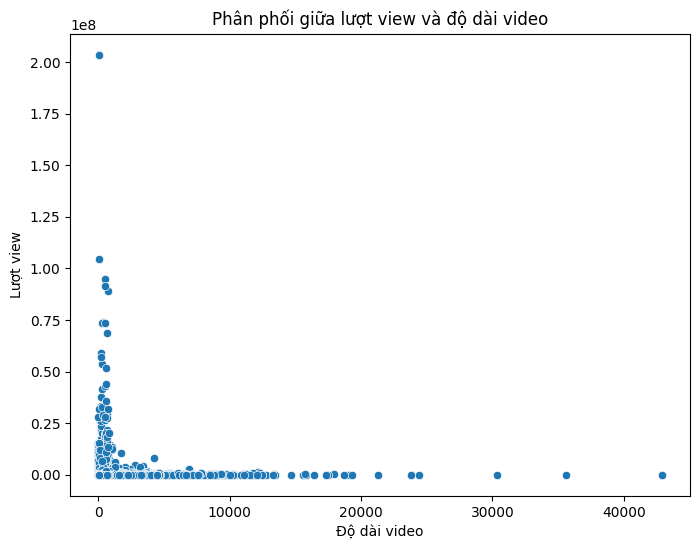

In [59]:
# Vẽ biểu đồ phân phối giữa view và độ dài video
plt.figure(figsize=(8, 6))
sns.scatterplot(x='duration', y='views', data=data)
plt.title('Phân phối giữa lượt view và độ dài video')
plt.xlabel('Độ dài video')
plt.ylabel('Lượt view')
plt.show()

Nhận xét:
    video có thời gian ngắn thường có nhiều view cao hơn những video có độ dài lớn. 

In [60]:
data = data.drop('dislikes', axis=1)
data = data.drop('favorite_count', axis=1)

Lưu dữ liệu sau khi làm sạch vào file clean data 

In [61]:
data.to_csv('clean_data_bigDS.csv',index=False)

Biểu đồ phân phối lượt views dựa vào subscribers

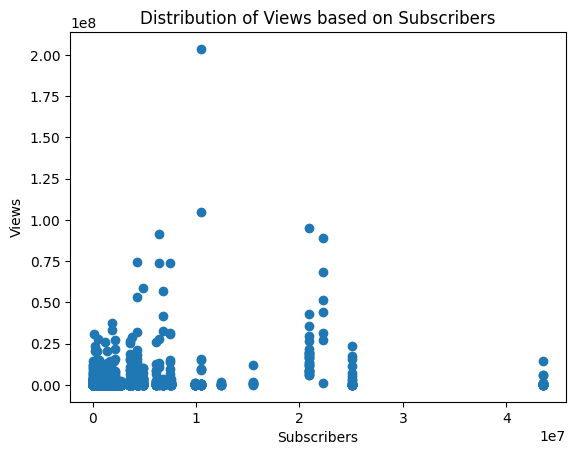

In [62]:
plt.scatter(data['subscribers'], data['views'])
plt.xlabel('Subscribers')
plt.ylabel('Views')
plt.title('Distribution of Views based on Subscribers')
plt.show()

Nhận xét:

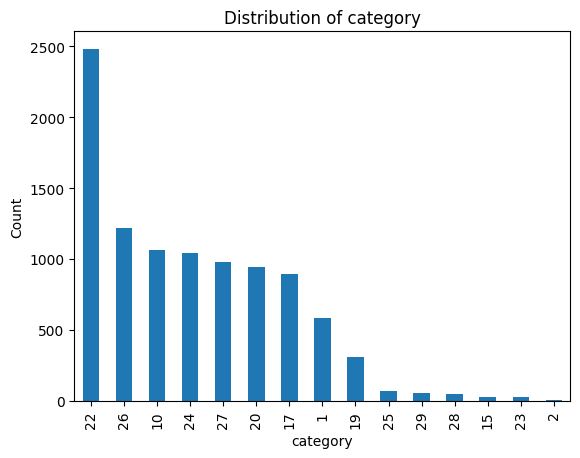

In [63]:
import matplotlib.pyplot as plt
def plot_data(column):
    data[column].value_counts().plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title('Distribution of ' + column)
    plt.show()

plot_data('category')

Nhận xét:
    Đối với các danh mục khác nhau thì số lượng video đăng tải cũng khác nhau

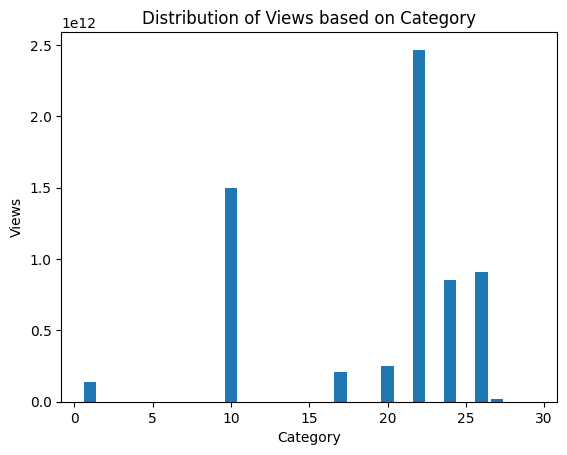

In [64]:
category_views = {}

for category in data['category']:
    if category in category_views:
        category_views[category] += data[data['category'] == category]['views'].sum()
    else:
        category_views[category] = data[data['category'] == category]['views'].sum()

categories = list(category_views.keys())
views = list(category_views.values())

plt.bar(categories, views)
plt.xlabel('Category')
plt.ylabel('Views')
plt.title('Distribution of Views based on Category')
plt.show()

Nhận xét:
    Danh mục video cũng ảnh hưởng đến lượt xem của video đó.

Biểu đồ thời gian thể hiện xu hướng lượt view thay đổi theo thời gian.

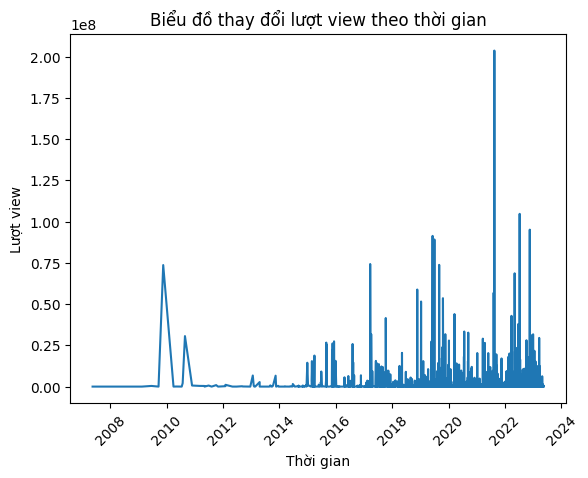

In [65]:
data['timestamp'] = pd.to_datetime(data['published_date'])
data = data.sort_values(by='timestamp')

plt.plot(data['timestamp'], data['views'])
plt.xlabel('Thời gian')
plt.ylabel('Lượt view')
plt.title('Biểu đồ thay đổi lượt view theo thời gian')
plt.xticks(rotation=45)
plt.show()

Nhận xét: đối với những video được đăng trong những năm gần đây thì lượt xem cao hơn.

#### Thêm đặc trưng mới

Tạo đặc trưng số lượng từ trong tiêu đề và mô tả

In [66]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def get_description_len(x):
    if isinstance(x, str):
        return len(nltk.word_tokenize(x))
    else:
        return 0

data['description_len'] = data['video_description'].apply(get_description_len)
data['title_len'] = data['video_title'].apply(lambda x: len(word_tokenize(x)))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tạo đặc trưng thời gian từ lúc video được đăng

In [67]:
import pytz

current_time = datetime.now(pytz.UTC)
data['days_since_published'] = (current_time - data['published_date']).dt.total_seconds()

In [68]:
data.isnull().sum()

video_id                   0
channel_id                 0
channel_name               0
published_date             0
video_title                0
video_description       1219
likes                      0
views                      0
comment_count              0
category                   0
subscribers                0
duration                   0
timestamp                  0
description_len            0
title_len                  0
days_since_published       0
dtype: int64

<Axes: >

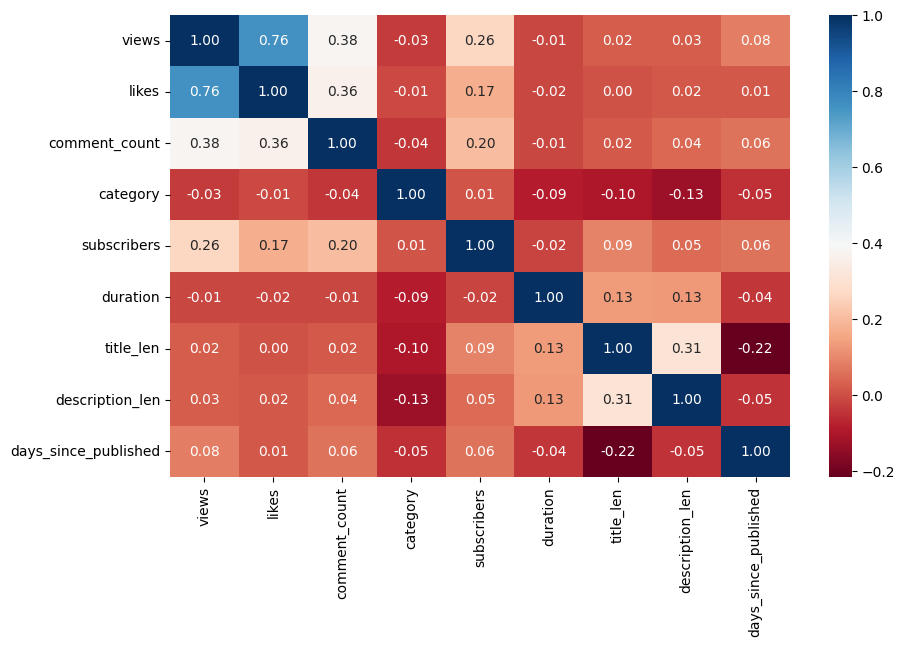

In [69]:
features = ['views','likes','comment_count','category','subscribers','duration','title_len','description_len','days_since_published']
corr_= data[features].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "RdBu")

### Xử lý ngoại lệ


In [70]:
def outliers_gaussion(data, feature):
    uppper_boundary = data[feature].mean() + 3*data[feature].std()
    lower_boundary = data[feature].mean() - 3*data[feature].std()
    data.loc[data[feature] < lower_boundary, feature] = lower_boundary
    data.loc[data[feature] > uppper_boundary, feature] = uppper_boundary

In [71]:
from sklearn.preprocessing import MinMaxScaler

features = ['views','likes','category','comment_count','subscribers','duration','title_len','description_len','days_since_published']

df = data.copy()
for var in features:
        df[var]= (data[var]+1).apply(np.log)
        outliers_gaussion(df, var)

Kĩ thuật biến đổi dữ liệu (lấy logarit) được thực hiện trên các tính năng có giá trị dữ liệu số để chuyển đổi chúng thành gần với phân phối chuẩn và làm giảm sự biến động quá lớn của các giá trị, điều này được thực hiện vì có một số tính năng có phân phối dữ liệu sai lệch.

Chọn đặc trưng

In [72]:
fea = ['category','subscribers','duration','title_len','description_len','days_since_published']
X = df[fea]
y = df['views']

#### Tách theo tỉ lệ: 70% : 15% : 15% lần lượt cho bộ train, bộ validation, bộ test (dựa vào phương pháp phân phối dữ liệu cổ điển).

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=8)

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_regression(pred, y_val):
    print("MAE: %.2f" % mean_absolute_error(y_val, pred))
    print("RMSE: %.2f" % mean_squared_error(y_val, pred, squared=False))
    print('R2 score: %.2f' % r2_score(y_val, pred)) 

Ý nghĩa:
* MAE: sự chênh lệch trung bình giữa giá trị dự đoán và giá trị thực tế của số lượt xem.
* RMSE: đánh giá khác về sự chênh lệch giữa giá trị dự đoán và giá trị thực tế của số lượt xem. Nó tính toán bình phương trung bình của các sai số và rút căn để đưa về đơn vị gốc. RMSE có ưu điểm là nếu có sai số lớn, nó sẽ có trọng số cao hơn so với MAE.
* R2 score (R-squared score): đánh giá mức độ phù hợp của mô hình dự đoán với dữ liệu thực tế. 

### Chuẩn hóa dữ liệu

In [75]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_val_scaler = scaler.transform(X_val)
X_test_scaler = scaler.transform(X_test)


Trực quan hóa dữ liệu trước và sau chuẩn hóa

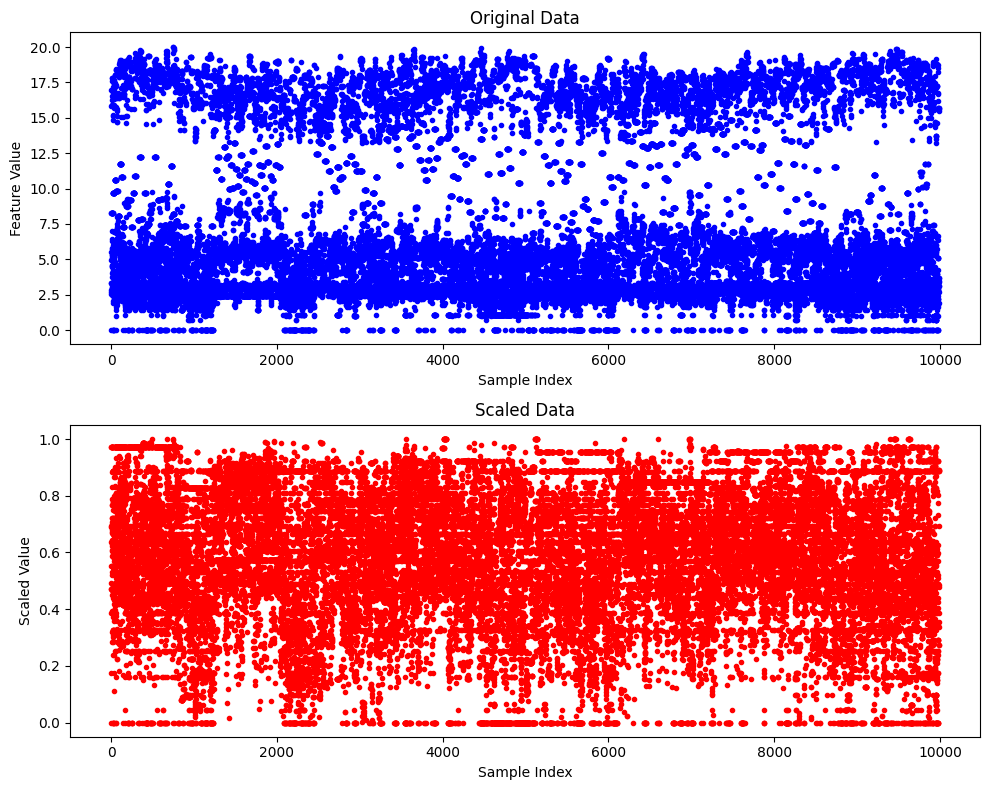

In [76]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(X_train.index, X_train, 'bo', markersize=3)
axs[0].set_title('Original Data')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Feature Value')
axs[1].plot(X_train.index, X_train_scaler, 'ro', markersize=3)
axs[1].set_title('Scaled Data')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Scaled Value')
plt.tight_layout()
plt.show()

Nhận xét:
* Biểu đồ trước khi chuẩn hóa dữ liệu cho thấy các đặc trưng có phạm vi giá trị khác nhau và không đồng nhất
* Sau khi chuẩn hóa, biểu đồ cho thấy các đặc trưng đã được đưa về cùng một phạm vi [0, 1]. Điều này cho thấy các giá trị của các dữ liệu nằm gần nhau và không bị chênh lệch lớn về giá trị. 

Điều này cho thấy việc chuẩn hóa đã giúp đồng nhất dữ liệu và đưa các đặc trưng về cùng một thang đo.

### Kĩ thuật lựa chọn đặc trưng 

In [77]:
from sklearn.feature_selection import SelectKBest, f_regression

select_k_best = SelectKBest(score_func=f_regression, k=5)
X_train_selected = select_k_best.fit_transform(X_train_scaler, y_train)
selected_feature_indices = select_k_best.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]

print("Selected Features:", selected_feature_names)

X_train_select = X_train_scaler[:, selected_feature_indices]
X_val_select = X_val_scaler[:, selected_feature_indices]
X_test_select = X_test_scaler[:, selected_feature_indices]


Selected Features: Index(['category', 'subscribers', 'duration', 'title_len', 'description_len'], dtype='object')


### Model Random Forest ###

* Lựa chọn 5 đặc trưng

In [93]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=104)
best_model1 = rf.fit(X_train_scaler, y_train)

category                0.037337
subscribers             0.721134
duration                0.061878
title_len               0.035642
description_len         0.054534
days_since_published    0.089477
dtype: float64
5 đặc trưng của pp random forest:
['subscribers', 'days_since_published', 'duration', 'description_len', 'category']


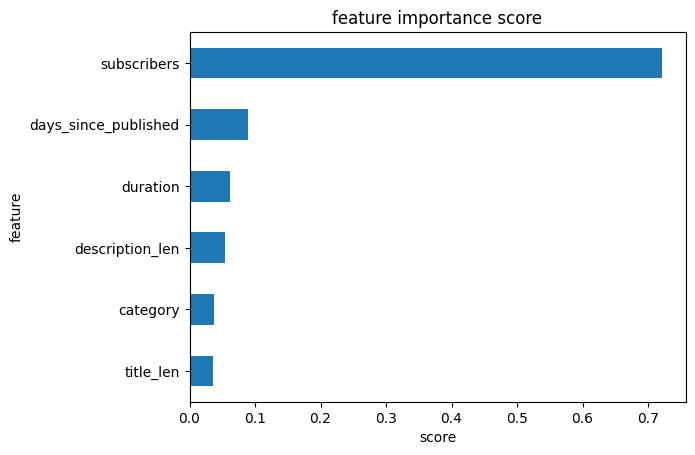

In [94]:
X=data[fea]
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(10).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')
print(feat_importances)
top5_feature_rf = feat_importances.nlargest(5).index.tolist()
print("5 đặc trưng của pp random forest:")
print(top5_feature_rf)

Nhận xét: 

Do cách tiếp cận và phương pháp tính toán khác nhau, SelectKBest và Random Forest có thể cho kết quả khác nhau khi chọn đặc trưng.Nhưng RandomForest lại tốt hơn trong trường hợp này

* Sử dụng kĩ thuật lựa chọn đặc trưng SelectKBest

In [80]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=104)
best_model1 = rf.fit(X_train_select, y_train)
pred = rf.predict(X_val_select)
print(rf.get_params())
eval_regression(pred, y_val)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 104, 'verbose': 0, 'warm_start': False}
MAE: 1.10
RMSE: 1.49
R2 score: 0.80


* Nếu sử dụng các đặc trưng từ random forest

In [81]:
feature_indices = [X_train.columns.get_loc(feature_name) for feature_name in top5_feature_rf]
X_train_rf = X_train_scaler[:, feature_indices]
X_val_rf = X_val_scaler[:, feature_indices]
X_test_rf = X_test_scaler[:, feature_indices]


In [82]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=104)
best_model1 = rf.fit(X_train_rf, y_train)
pred = rf.predict(X_val_rf)
print(rf.get_params())
eval_regression(pred, y_val)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 104, 'verbose': 0, 'warm_start': False}
MAE: 1.00
RMSE: 1.37
R2 score: 0.83


### Model Linear Regression ###

In [83]:
from sklearn.linear_model import LinearRegression

lr  = LinearRegression()
lr.fit(X_train_select, y_train)
y_pred = lr.predict(X_val_select)
print("Đặc trưng được chọn từ SelectKBest")
eval_regression(y_pred, y_val)

lr  = LinearRegression()
lr.fit(X_train_rf, y_train)
y_pred = lr.predict(X_val_rf)
print("\nĐặc trưng được chọn từ Randomforest")
eval_regression(y_pred, y_val)

Đặc trưng được chọn từ SelectKBest
MAE: 1.48
RMSE: 1.88
R2 score: 0.69

Đặc trưng được chọn từ Randomforest
MAE: 1.46
RMSE: 1.86
R2 score: 0.70


### Model Support Vector Regressor

In [84]:
from sklearn.svm import SVR

print("Đặc trưng được chọn từ SelectKBest")
svr = SVR()
svr.fit(X_train_select, y_train)
pred = svr.predict(X_val_select)
eval_regression(pred, y_val)

print("\nĐặc trưng được chọn từ Randomforest")
svr = SVR()
svr.fit(X_train_rf, y_train)
pred = svr.predict(X_val_rf)
eval_regression(pred, y_val)

Đặc trưng được chọn từ SelectKBest
MAE: 1.42
RMSE: 1.85
R2 score: 0.70

Đặc trưng được chọn từ Randomforest
MAE: 1.36
RMSE: 1.77
R2 score: 0.72


Phương pháp lựa chọn đặc trưng Random Forest có thể cho kết quả độ chính xác cao hơn so với SelectKBest, nhờ khả năng tìm hiểu mối quan hệ phi tuyến và xử lý các đặc trưng không đồng nhất, trong khi SelectKBest chỉ chọn các đặc trưng dựa trên các phép đo thống kê đơn lẻ. Tuy nhiên, việc sử dụng Random Forest cần đánh đổi với thời gian huấn luyện và tính toán phức tạp hơn. 

### Lựa chọn các siêu tham số

#### Model Random Forest

In [85]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa các giá trị của các siêu tham số cần tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    "max_features": ["sqrt","log2"]
}

rf = RandomForestRegressor()
rf_grid_search = GridSearchCV(rf, param_grid, cv=5)
rf_grid_search.fit(X_train_rf, y_train)

print("Best Hyperparameters:", rf_grid_search.best_params_)

y_pred = rf_grid_search.predict(X_val_rf)
eval_regression(y_pred, y_val)

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
MAE: 1.01
RMSE: 1.38
R2 score: 0.83


#### Model Linear Resgressor

In [86]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'fit_intercept': [True, False],
}
lr = LinearRegression()
print("\nĐặc trưng được chọn từ Randomforest")
lr_grid_searchrf = GridSearchCV(lr, param_grid, cv=5)
lr_grid_searchrf.fit(X_train_rf, y_train)
print("Best Hyperparameters:", lr_grid_searchrf.best_params_)
y_pred = lr_grid_searchrf.predict(X_val_rf)
eval_regression(y_pred, y_val)


Đặc trưng được chọn từ Randomforest
Best Hyperparameters: {'fit_intercept': True}
MAE: 1.46
RMSE: 1.86
R2 score: 0.70


#### Model Support Vector Regressor

In [87]:
from sklearn.model_selection import GridSearchCV

param_grid = {
'C': [0.1, 1, 10],
'kernel': ['linear', 'rbf'],
'gamma': ['scale', 'auto'],
'epsilon': [0.1, 0.2, 0.3]
}
svr = SVR()
print("\nĐặc trưng được chọn từ Randomforest")
svr_grid_searchrf = GridSearchCV(svr, param_grid, cv=5)
svr_grid_searchrf.fit(X_train_rf, y_train)
print("Best Hyperparameters:", svr_grid_searchrf.best_params_)
y_pred = svr_grid_searchrf.predict(X_val_rf)
eval_regression(y_pred, y_val)


Đặc trưng được chọn từ Randomforest
Best Hyperparameters: {'C': 10, 'epsilon': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
MAE: 1.33
RMSE: 1.75
R2 score: 0.73


### Đánh giá kết quả

RandomForest

In [88]:
y_pred = rf_grid_search.predict(X_test_rf)
eval_regression(y_pred, y_test)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse= mean_squared_error(y_test, y_pred, squared=False)
rf_r2 = r2_score(y_test, y_pred)

MAE: 1.04
RMSE: 1.44
R2 score: 0.80


Linear Regressor

In [89]:
y_pred = lr_grid_searchrf.predict(X_test_rf)
eval_regression(y_pred, y_test)
lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse= mean_squared_error(y_test, y_pred, squared=False)
lr_r2 = r2_score(y_test, y_pred)

MAE: 1.49
RMSE: 1.91
R2 score: 0.66


Support Vector Regressor

In [90]:
y_pred = svr_grid_searchrf.predict(X_test_rf)
eval_regression(y_pred, y_test)
svr_mae = mean_absolute_error(y_test, y_pred)
svr_rmse= mean_squared_error(y_test, y_pred, squared=False)
svr_r2 = r2_score(y_test, y_pred)

MAE: 1.33
RMSE: 1.76
R2 score: 0.71


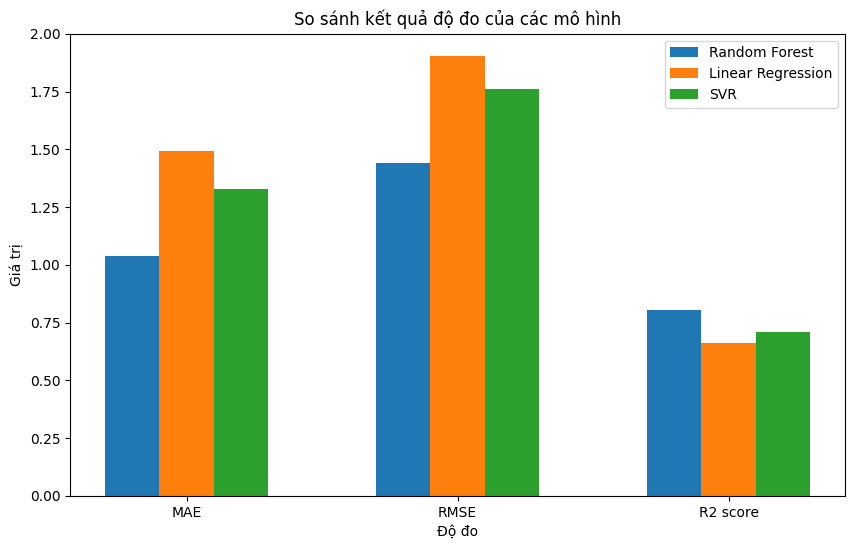

In [91]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['MAE', 'RMSE', 'R2 score']
model_names = ['Random Forest', 'Linear Regression', 'SVR']
rf_scores = [rf_mae, rf_rmse, rf_r2]
lr_scores = [lr_mae, lr_rmse, lr_r2]
svr_scores = [svr_mae, svr_rmse, svr_r2]

num_metrics = len(metrics)
num_models = len(model_names)
x = np.arange(num_metrics)
bar_width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x, rf_scores, width=bar_width, label='Random Forest')
plt.bar(x + bar_width, lr_scores, width=bar_width, label='Linear Regression')
plt.bar(x + 2*bar_width, svr_scores, width=bar_width, label='SVR')

plt.xlabel('Độ đo')
plt.ylabel('Giá trị')
plt.title('So sánh kết quả độ đo của các mô hình')
plt.xticks(x + bar_width, metrics)
plt.legend()
plt.show()


### Trực quan hóa kết quả

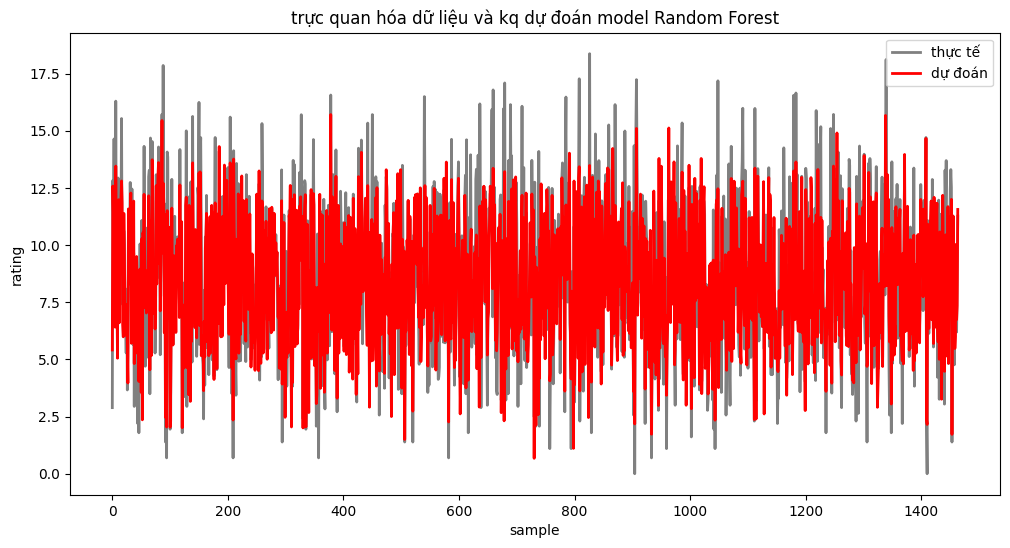

In [92]:
def dothi(samples, y_true , y_pred, model):
    plt.figure(figsize=(12,6))
    plt.plot(samples, y_true, color='gray',linewidth=2, label ='thực tế')
    plt.plot(samples, y_pred, color ='red', linewidth=2, label ='dự đoán')
    plt.xlabel('sample')
    plt.ylabel('rating')
    plt.title("trực quan hóa dữ liệu và kq dự đoán model " + model)
    plt.legend()
    plt.show()
    
samples = range(len(y_test))
model_name = "Random Forest"

dothi(samples, y_test, y_pred, model_name)
